In [1]:
# # %uv pip install torch==2.0.0+cpu --index-url https://download.pytorch.org/whl/cpu
# %pip install torch-cluster torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
# %pip install torch-geometric==2.3.1
# %pip install matplotlib pandas scikit-learn tqdm numpy networkx

In [2]:
from torch_geometric.datasets import Planetoid

/home/ken/workspace/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# torch_geometric の Dataset としてダウンロード
dataset = Planetoid(root="./dataset", name="Cora", split="full")

In [4]:
print(f"データセットの型 : {type(dataset)}")
print(f"ネットワークの型 : {type(dataset._data)}")

print(dataset[0])

データセットの型 : <class 'torch_geometric.datasets.planetoid.Planetoid'>
ネットワークの型 : <class 'torch_geometric.data.data.Data'>
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [5]:
from torch_geometric.utils import to_networkx

cora_network = to_networkx(dataset._data, node_attrs=["y"])

print(f"{type(cora_network)=}")
print(f"{cora_network.number_of_nodes()=}, {cora_network.number_of_edges()=}")

type(cora_network)=<class 'networkx.classes.digraph.DiGraph'>
cora_network.number_of_nodes()=2708, cora_network.number_of_edges()=10556


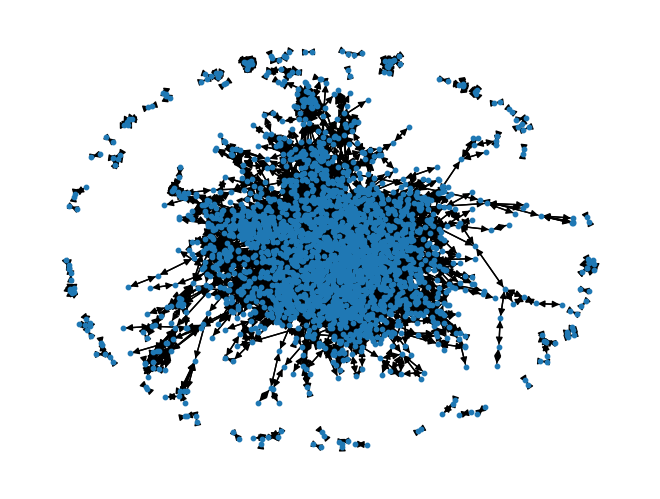

In [6]:
import networkx as nx

nx.draw(cora_network, node_size=10)

In [7]:
from collections import Counter
from pprint import pprint

# 各論文の技術領域に対応するIDを取得
labels = nx.get_node_attributes(cora_network, "y")
label_counter = Counter(labels.values())
pprint(labels)
pprint(labels.values())
pprint(label_counter)

{0: 3,
 1: 4,
 2: 4,
 3: 0,
 4: 3,
 5: 2,
 6: 0,
 7: 3,
 8: 3,
 9: 2,
 10: 0,
 11: 0,
 12: 4,
 13: 3,
 14: 3,
 15: 3,
 16: 2,
 17: 3,
 18: 1,
 19: 3,
 20: 5,
 21: 3,
 22: 4,
 23: 6,
 24: 3,
 25: 3,
 26: 6,
 27: 3,
 28: 2,
 29: 4,
 30: 3,
 31: 6,
 32: 0,
 33: 4,
 34: 2,
 35: 0,
 36: 1,
 37: 5,
 38: 4,
 39: 4,
 40: 3,
 41: 6,
 42: 6,
 43: 4,
 44: 3,
 45: 3,
 46: 2,
 47: 5,
 48: 3,
 49: 4,
 50: 5,
 51: 3,
 52: 0,
 53: 2,
 54: 1,
 55: 4,
 56: 6,
 57: 3,
 58: 2,
 59: 2,
 60: 0,
 61: 0,
 62: 0,
 63: 4,
 64: 2,
 65: 0,
 66: 4,
 67: 5,
 68: 2,
 69: 6,
 70: 5,
 71: 2,
 72: 2,
 73: 2,
 74: 0,
 75: 4,
 76: 5,
 77: 6,
 78: 4,
 79: 0,
 80: 0,
 81: 0,
 82: 4,
 83: 2,
 84: 4,
 85: 1,
 86: 4,
 87: 6,
 88: 0,
 89: 4,
 90: 2,
 91: 4,
 92: 6,
 93: 6,
 94: 0,
 95: 0,
 96: 6,
 97: 5,
 98: 0,
 99: 6,
 100: 0,
 101: 2,
 102: 1,
 103: 1,
 104: 1,
 105: 2,
 106: 6,
 107: 5,
 108: 6,
 109: 1,
 110: 2,
 111: 2,
 112: 1,
 113: 5,
 114: 5,
 115: 5,
 116: 6,
 117: 5,
 118: 6,
 119: 5,
 120: 5,
 121: 1,
 122: 6,
 12

<BarContainer object of 7 artists>

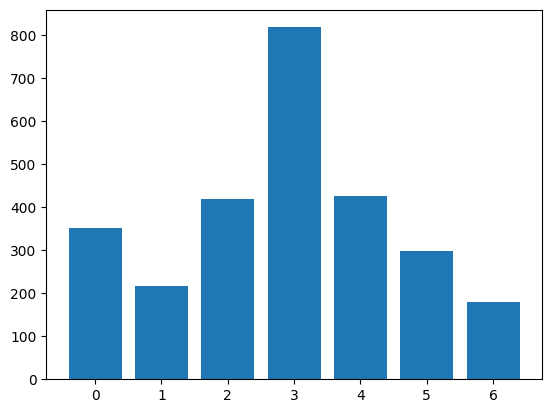

In [8]:
# ラベル分布を可視化
import matplotlib.pyplot as plt

plt.bar(
    label_counter.keys(),
    label_counter.values(),
    tick_label=[str(i) for i in label_counter.keys()],
)

### train, test splitting

In [9]:
from torch_geometric.transforms import RandomNodeSplit

node_splitter = RandomNodeSplit(
    split="train_rest",
    num_splits=1,
    num_val=0.0,
    num_test=0.4,
    key="y",
)

splitted_data = node_splitter(
    dataset._data
)

print(splitted_data.node_attrs())
print(splitted_data.train_mask)
print(splitted_data.test_mask)
print(f"{splitted_data.train_mask.shape=}")
print(f"{splitted_data.test_mask.shape=}")

['x', 'train_mask', 'val_mask', 'test_mask', 'y']
tensor([ True,  True,  True,  ..., False,  True,  True])
tensor([False, False, False,  ...,  True, False, False])
splitted_data.train_mask.shape=torch.Size([2708])
splitted_data.test_mask.shape=torch.Size([2708])


### node2vec

In [10]:
import torch
from torch_geometric.nn import Node2Vec

# node2vecモデルの定義
device = "cuda" if torch.cuda.is_available() else "cpu"

n2v_model = Node2Vec(
    splitted_data.edge_index,
    embedding_dim=64,
    walk_length=5,
    context_size=5,
    walks_per_node=10, # 1ノードあたりのランダムウォークの実行回数
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=False,
).to(device)

n2v_optimizer = torch.optim.Adam(
    list(n2v_model.parameters()),
    lr=0.01,
)

In [11]:
print(n2v_model)

Node2Vec(2708, 64)


In [12]:
from tqdm import tqdm


def train_n2v()->float:
    n2v_model.train()
    total_loss = 0.0

    loader=n2v_model.loader(
        batch_size=8,
        shuffle=True
    )

    # 教師なしの手法であるため、predictは不要である。
    for pos_rw, neg_rw in tqdm(loader, desc="Node2Vec Training"):
        n2v_optimizer.zero_grad()

        loss=n2v_model.loss(
            pos_rw.to(device),
            neg_rw.to(device),
        )

        loss.backward()
        n2v_optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

In [13]:
for epoch in range(30):
    loss = train_n2v()
    print(f"Epoch {epoch+1:03d}, Loss: {loss:.4f}")

Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 513.51it/s]


Epoch 001, Loss: 5.6489


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 644.84it/s]


Epoch 002, Loss: 3.7245


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 599.20it/s]


Epoch 003, Loss: 2.9526


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 512.15it/s]


Epoch 004, Loss: 2.4236


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 635.43it/s]


Epoch 005, Loss: 2.0525


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 648.93it/s]


Epoch 006, Loss: 1.7523


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 498.16it/s]


Epoch 007, Loss: 1.5223


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 650.96it/s]


Epoch 008, Loss: 1.3600


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 647.73it/s]


Epoch 009, Loss: 1.2215


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 612.10it/s]


Epoch 010, Loss: 1.1255


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 528.38it/s]


Epoch 011, Loss: 1.0427


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 572.24it/s]


Epoch 012, Loss: 0.9891


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 644.49it/s]


Epoch 013, Loss: 0.9505


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 587.78it/s]


Epoch 014, Loss: 0.9252


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 540.63it/s]


Epoch 015, Loss: 0.9005


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 650.82it/s]


Epoch 016, Loss: 0.8886


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 645.42it/s]


Epoch 017, Loss: 0.8807


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 492.91it/s]


Epoch 018, Loss: 0.8716


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 630.76it/s]


Epoch 019, Loss: 0.8730


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 643.53it/s]


Epoch 020, Loss: 0.8702


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 571.85it/s]


Epoch 021, Loss: 0.8722


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 529.53it/s]


Epoch 022, Loss: 0.8711


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 626.82it/s]


Epoch 023, Loss: 0.8755


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 630.33it/s]


Epoch 024, Loss: 0.8736


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 595.20it/s]


Epoch 025, Loss: 0.8738


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 534.41it/s]


Epoch 026, Loss: 0.8790


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 647.83it/s]


Epoch 027, Loss: 0.8772


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 631.41it/s]


Epoch 028, Loss: 0.8793


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 544.10it/s]


Epoch 029, Loss: 0.8784


Node2Vec Training: 100%|██████████| 339/339 [00:00<00:00, 592.16it/s]

Epoch 030, Loss: 0.8745


In [14]:
embedding_matrix = n2v_model.embedding(
    torch.arange(splitted_data.num_nodes)
)
print(embedding_matrix.shape)
print(embedding_matrix)

torch.Size([2708, 64])
tensor([[ 0.4541,  0.1216, -0.0188,  ...,  0.2646, -0.4552, -0.0722],
        [-0.2529,  0.1386, -0.0242,  ...,  0.4019,  0.2588,  0.0733],
        [-0.2643,  0.0140, -0.3008,  ..., -0.0448,  0.3770,  0.4060],
        ...,
        [-0.3967, -0.5480,  0.2171,  ...,  0.0605, -0.3715, -0.6193],
        [ 0.4041, -0.5310, -0.4208,  ..., -0.5499,  0.1043, -0.1592],
        [ 0.5447, -0.1380, -0.3632,  ..., -0.6107,  0.1472,  0.1673]],
       grad_fn=<EmbeddingBackward0>)


### 未学習のデータのノード特徴量を用いて学習/予測させてみる

In [15]:
# 元データ
print(splitted_data.x.shape)
print(splitted_data.x)

torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

baseline_classifier = LogisticRegression(
    max_iter=1000,
    random_state=0,
)

X_train = splitted_data.x[splitted_data.train_mask].numpy()
y_train = splitted_data.y[splitted_data.train_mask].numpy()
baseline_classifier.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [17]:

# 評価データに対する推論
X_test = splitted_data.x[splitted_data.test_mask].numpy()
y_true = splitted_data.y[splitted_data.test_mask].numpy()
y_pred = baseline_classifier.predict(X_test)

# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.65      0.65       144
           1       0.81      0.64      0.71        85
           2       0.88      0.83      0.85       158
           3       0.68      0.84      0.75       300
           4       0.80      0.74      0.77       184
           5       0.75      0.73      0.74       132
           6       0.83      0.56      0.67        80

    accuracy                           0.75      1083
   macro avg       0.77      0.71      0.74      1083
weighted avg       0.76      0.75      0.75      1083



### Node2Vecで学習した埋め込みを元データの特徴量に追加して、新しい特徴量を構成する

In [18]:
n2v_classifier = LogisticRegression(
    max_iter=1000,
    random_state=0,
)

X_train = torch.cat(
    (
        splitted_data.x[splitted_data.train_mask],
        embedding_matrix[splitted_data.train_mask],
    ),
    dim=1,
).detach().numpy()
y_train = splitted_data.y[splitted_data.train_mask].numpy()

n2v_classifier.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [19]:
X_test = torch.cat(
    (
        splitted_data.x[splitted_data.test_mask],
        embedding_matrix[splitted_data.test_mask],
    ),
    dim=1,
).detach().numpy()
y_test = splitted_data.y[splitted_data.test_mask].numpy()
y_pred = n2v_classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       144
           1       0.80      0.75      0.78        85
           2       0.91      0.87      0.89       158
           3       0.76      0.83      0.80       300
           4       0.82      0.80      0.81       184
           5       0.81      0.80      0.81       132
           6       0.79      0.62      0.70        80

    accuracy                           0.79      1083
   macro avg       0.80      0.77      0.78      1083
weighted avg       0.80      0.79      0.79      1083

